# Aula 13 - Aprendizado não-supervisionado

Neste notebook iremos utilizar a biblioteca [Keras](https://www.keras.io) para construir redes neurais do tipo Autoencoder e Generative Adversarial Networks (GANs).

## Parte 1 - Autoencoders

Neste exemplo, utilizaremos uma rede autoencoder para eliminar ruído (adicionado por nós) do dataset MNIST. Primeiramente, precisamos importar algumas bibliotecas.

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

Em seguida, podemos importar o dataset e fazer alguns pré-processamentos básicos.

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11501568/11490434 [==============================] - 0s 0us/step


Para adicionar ruído no dataset, basta somar o valor de cada pixel com um ruído gerado a partir de uma distribuição normal, conforme abaixo.

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

As imagens resultantes são apresentadas abaixo.

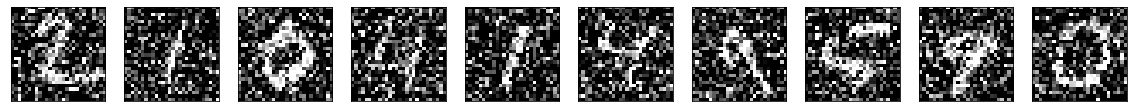

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Nosso próximo passo é criar o autoencoder. Nosso autoencoder recebe imagens no formato 28x28x1 e aplica duas camadas de convolução e max pooling, chegando a uma representação compacta de 7x7x32. Esta é a parte encoder do nosso autoencoder. Em seguida, temos o decoder, que recebe a imagem no formato 7x7x32 e, após duas camadas de convolução e upsampling, gera uma imagem final de 32x32x1, mesmo formato da imagem original.

In [ ]:
autoencoder = Sequential()

autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))

# at this point the representation is (7, 7, 32)

autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 32)       0

Criado o modelo, podemos agora iniciar o treino. Para acelerar o processo, utilizamos um batch de tamanho 256.

In [ ]:
hist = autoencoder.fit(x_train_noisy, x_train,
                        epochs=10,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_test_noisy, x_test))

Epoch 1/10
235/235 [==============================] - 15s 13ms/step - loss: 0.1961 - val_loss: 0.1264
Epoch 2/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1211 - val_loss: 0.1149
Epoch 3/10
235/235 [==============================] - 3s 12ms/step - loss: 0.1140 - val_loss: 0.1109
Epoch 4/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1101 - val_loss: 0.1080
Epoch 5/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1074 - val_loss: 0.1079
Epoch 6/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1058 - val_loss: 0.1041
Epoch 7/10
235/235 [==============================] - 3s 13ms/step - loss: 0.1046 - val_loss: 0.1032
Epoch 8/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1037 - val_loss: 0.1023
Epoch 9/10
235/235 [==============================] - 3s 12ms/step - loss: 0.1029 - val_loss: 0.1017
Epoch 10/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1021 - val_l

Podemos visualizar a evolução do loss ao longo das épocas como segue.

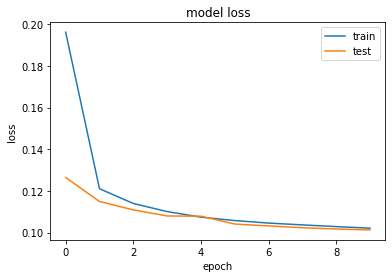

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Finalmente, agora podemos testar nosso autoencoder. Para isto, podemos passar o conjunto de teste, obtendo as saídas correspondentes. Em seguida, podemos plotar a imagem original, a imagem com ruído, e a imagem resultante (produzida pelo autoencoder).

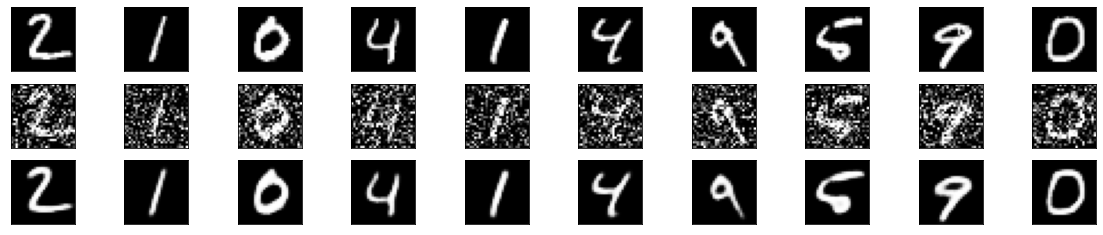

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original with noise
    ax = plt.subplot(3, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Parte 2 - Generative Adversarial Networks (GANs)

Neste exemplo, utilizaremos uma GAN para gerar dígitos escritos à mão com base no dataset MNIST. Abaixo, as bibliotecas necessárias.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Dense, GlobalMaxPooling2D, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

O próximo passo é carregar o dataset e realizar alguns pré-processamentos.

In [ ]:
# We use both the training & test MNIST digits
(x_train, _), (x_test, _) = mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))

dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(64).prefetch(32)

Agora podemos começar a construir as redes. Vamos começar com o discriminador, responsável por diferenciar imagens reais de fakes. Para isto, ele recebe imagens no formato 28x28x1 e, através de convoluções, classifica as imagens em reais ou fakes.

In [ ]:
discriminator = Sequential(name="discriminator")
discriminator.add(Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.2), strides=(2, 2), padding="same", input_shape=(28, 28, 1)))
discriminator.add(Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.2), strides=(2, 2), padding="same"))
discriminator.add(GlobalMaxPooling2D())
discriminator.add(Dense(1))
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 conv2d_52 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 global_max_pooling2d_7 (Glo  (None, 128)              0         
 balMaxPooling2D)                                                
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________________________


Agora podemos construir o gerador, responsável por gerar as imagens fake. Para isto, o gerador utiliza uma representação latente que, através de convoluções transpostas, gera imagens de 28x28x1.

In [ ]:
latent_dim = 128
generator = Sequential(name="generator")
generator.add(Dense(7 * 7 * 128, activation=LeakyReLU(alpha=0.2), input_shape=(latent_dim,)))
generator.add(Reshape((7, 7, 128)))
generator.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation=LeakyReLU(alpha=0.2)))
generator.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation=LeakyReLU(alpha=0.2)))
generator.add(Conv2D(1, (7, 7), padding="same", activation="sigmoid"))
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 6272)              809088    
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 14, 14, 128)      262272    
 Transpose)                                                      
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 28, 28, 128)      262272    
 Transpose)                                                      
                                                                 
 conv2d_53 (Conv2D)          (None, 28, 28, 1)         6273      
                                                                 
Total params: 1,339,905
Trainable params: 1,339,905
Non-t

Existem diversas formas de se implementar uma GAN. Aqui, faremos isto através de uma subclasse de Model, que recebe o discriminador e gerador além de implementar métodos para compilar e treinar o modelo.

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

A classe abaixo é um callback para permitir a geração de amostras (imagens fake) após cada época.

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        plt.figure(figsize=(20, 4))
        for i in range(self.num_img):
            ax = plt.subplot(1, self.num_img, i+1)
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.savefig("generated_epoch_%03d.png" % (epoch), bbox_inches='tight')
        plt.savefig

Agora, finalmente, podemos criar nossa GAN. Note que a GAN recebe o discriminador e o gerador que criamos. Além disso, note que podemos definir um algoritmo de otimização para cada rede.

In [ ]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=Adam(learning_rate=0.0003),
    g_optimizer=Adam(learning_rate=0.0003),
    loss_fn=BinaryCrossentropy(from_logits=True),
)

Para treinar a rede, como de costume, basta chamar a função `fit`. Note que nossa classe de callback é passada como argumento para permitir a geração de amostras a cada época.

In [ ]:
epochs = 30
num_img = 10
hist = gan.fit(
    dataset, 
    epochs=epochs,
    callbacks=[GANMonitor(num_img=num_img, latent_dim=latent_dim)]
)

Para avaliar os desempenho da GAN, podemos utilizar o código abaixo. Note que o sucesso do gerador depende do fracasso do discriminador.

In [ ]:
plt.plot(hist.history['d_loss'])
plt.plot(hist.history['g_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['discriminator', 'generator'], loc='upper right')
plt.show()

Finalmente, podemos apresentar alguns exemplos. O código abaixo mostra um conjunto de amostras (geradas pelo callback) de cada época. Note que as imagens resultantes melhoram significativamente da primeira época para as últimas. Naturalmente, resultados melhores podem ser obtidos se a GAN for treinada por mais tempo.

In [ ]:
import cv2 as cv

plt.figure(figsize=(20, 10))
for i in range(1,epochs+1):
    ax = plt.subplot(epochs, 1, i, frameon=False)
    image = cv.imread("generated_epoch_%03d.png" % (i-1))
    plt.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.set_yticklabels([])
    ax.tick_params(axis='y', labelrotation=90)
    plt.ylabel("Epoch %03d" % (i-1), rotation=0, labelpad=25)
plt.show()

## Exercícios

### Exercício 1

Rode autoencoder visto acima para remover ruído das imagens do dataset CIFAR-10. Sua tarefa consiste em importar o dataset em questão, realizar seu pré-processamento, adicionar ruído, e ajustar a arquitetura da rede para obter resultados satisfatórios.

- importando e carregando arquivo.

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization
from keras.models import Sequential
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


- Aplicando ruído

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

- Criando o Autoencoder

In [ ]:
autoencoder = Sequential()
autoencoder.add(Conv2D(32, (3, 1), activation='relu', padding='same', input_shape=(32, 32, 3)))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(32, (3, 1), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
# at this point the representation is (7, 7, 32)
autoencoder.add(Conv2D(32, (3, 1), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 1), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))


autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 16, 16, 32)        3104      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 8, 8, 32)          3104      
                                                                 
 up_sampling2d_10 (UpSamplin  (None, 16, 16, 32)      

- Treinando o modelo

In [ ]:
hist = autoencoder.fit(x_train_noisy, x_train,
                        epochs=30,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_test_noisy, x_test))

Epoch 1/30
196/196 [==============================] - 5s 21ms/step - loss: 0.5953 - val_loss: 0.5769
Epoch 2/30
196/196 [==============================] - 4s 18ms/step - loss: 0.5741 - val_loss: 0.5735
Epoch 3/30
196/196 [==============================] - 4s 18ms/step - loss: 0.5717 - val_loss: 0.5720
Epoch 4/30
196/196 [==============================] - 4s 18ms/step - loss: 0.5707 - val_loss: 0.5713
Epoch 5/30
196/196 [==============================] - 4s 19ms/step - loss: 0.5701 - val_loss: 0.5707
Epoch 6/30
196/196 [==============================] - 4s 19ms/step - loss: 0.5697 - val_loss: 0.5704
Epoch 7/30
196/196 [==============================] - 4s 19ms/step - loss: 0.5693 - val_loss: 0.5703
Epoch 8/30
196/196 [==============================] - 4s 19ms/step - loss: 0.5691 - val_loss: 0.5699
Epoch 9/30
196/196 [==============================] - 4s 19ms/step - loss: 0.5689 - val_loss: 0.5698
Epoch 10/30
196/196 [==============================] - 4s 19ms/step - loss: 0.5686 - val_lo

- Testando o modelo

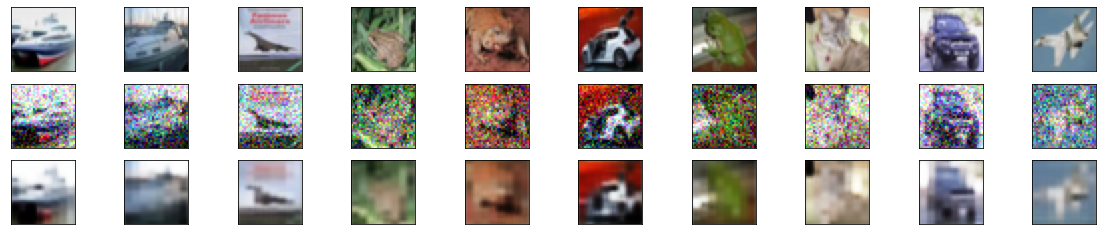

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original with noise
    ax = plt.subplot(3, n, i + n)
    plt.imshow(x_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Exercício 2

Ajuste a GAN vista acima para gerar resultados melhores do dataset MNIST. Sua tarefa consiste em modificar os parâmetros de treino da rede (e.g., otimizador, número de épocas, etc.).

- Nesse caso aumentei o número de épocas para 50.

Epoch 1/50
1094/1094 [==============================] - 34s 30ms/step - d_loss: 0.4541 - g_loss: 1.2344
Epoch 2/50
1094/1094 [==============================] - 32s 29ms/step - d_loss: 0.6265 - g_loss: 0.9093
Epoch 3/50
1094/1094 [==============================] - 32s 29ms/step - d_loss: 0.6510 - g_loss: 0.8352
Epoch 4/50
1094/1094 [==============================] - 32s 29ms/step - d_loss: 0.6517 - g_loss: 0.8290
Epoch 5/50
1094/1094 [==============================] - 32s 29ms/step - d_loss: 0.6447 - g_loss: 0.8465
Epoch 6/50
1094/1094 [==============================] - 33s 30ms/step - d_loss: 0.6492 - g_loss: 0.8397
Epoch 7/50
1094/1094 [==============================] - 32s 29ms/step - d_loss: 0.6448 - g_loss: 0.8450
Epoch 8/50
1094/1094 [==============================] - 32s 29ms/step - d_loss: 0.6341 - g_loss: 0.8661
Epoch 9/50
1094/1094 [==============================] - 32s 29ms/step - d_loss: 0.6251 - g_loss: 0.8785
Epoch 10/50
1094/1094 [==============================] - 32s 30m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


1094/1094 [==============================] - 32s 29ms/step - d_loss: 0.5983 - g_loss: 0.9478
Epoch 22/50
1094/1094 [==============================] - 32s 30ms/step - d_loss: 0.6023 - g_loss: 0.9329
Epoch 23/50
1094/1094 [==============================] - 32s 30ms/step - d_loss: 0.6044 - g_loss: 0.9300
Epoch 24/50
1094/1094 [==============================] - 32s 29ms/step - d_loss: 0.6070 - g_loss: 0.9297
Epoch 25/50
1094/1094 [==============================] - 32s 29ms/step - d_loss: 0.6073 - g_loss: 0.9311
Epoch 26/50
1094/1094 [==============================] - 33s 30ms/step - d_loss: 0.6086 - g_loss: 0.9293
Epoch 27/50
1094/1094 [==============================] - 33s 30ms/step - d_loss: 0.6084 - g_loss: 0.9270
Epoch 28/50
1094/1094 [==============================] - 32s 30ms/step - d_loss: 0.6083 - g_loss: 0.9272
Epoch 29/50
1094/1094 [==============================] - 33s 30ms/step - d_loss: 0.6091 - g_loss: 0.9281
Epoch 30/50
1094/1094 [==============================] - 33s 30ms/s

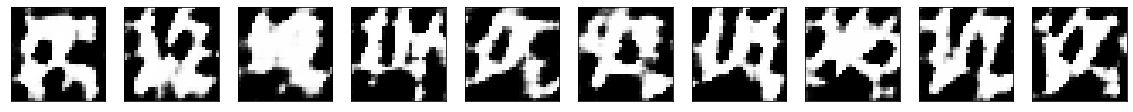

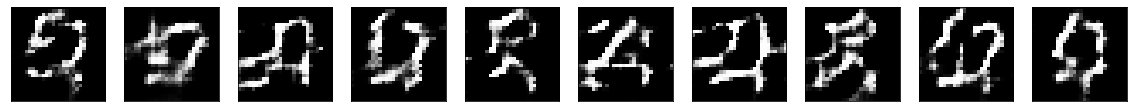

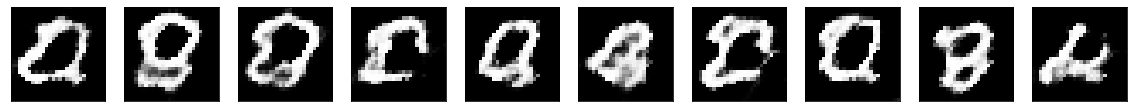

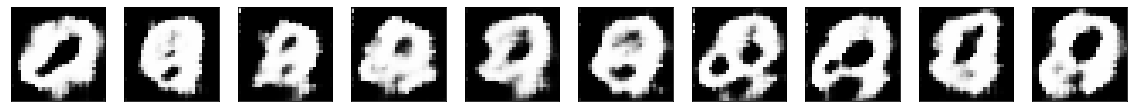

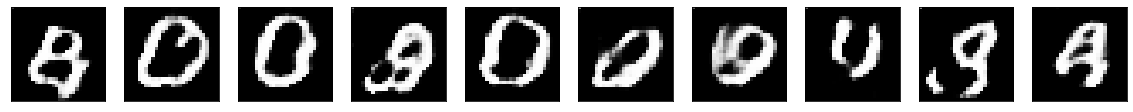

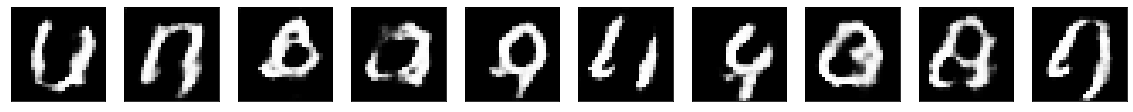

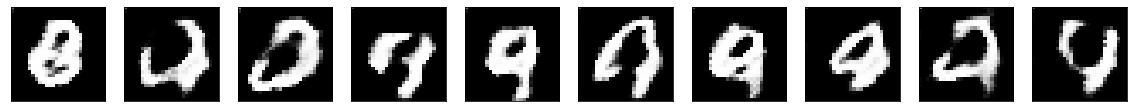

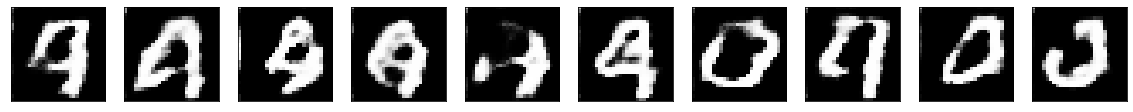

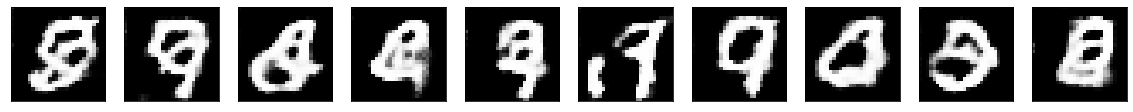

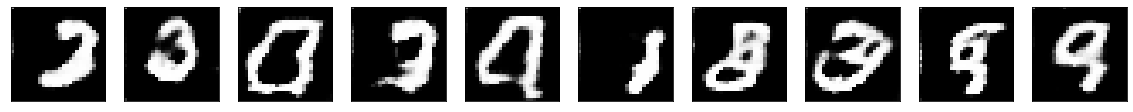

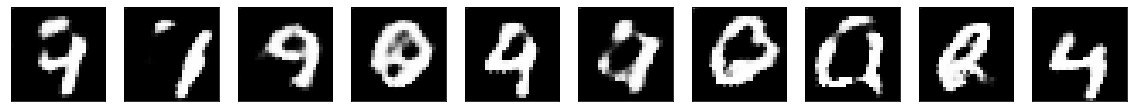

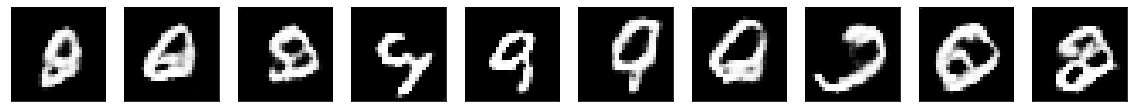

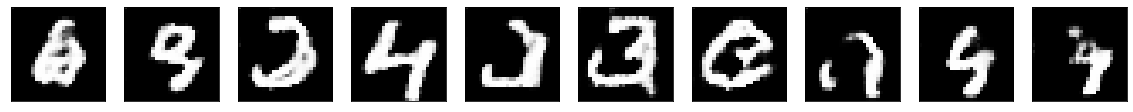

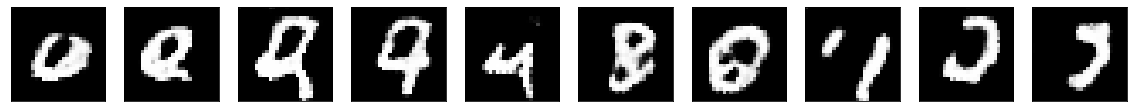

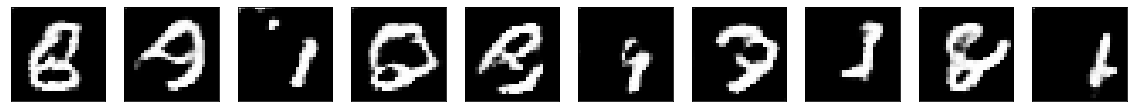

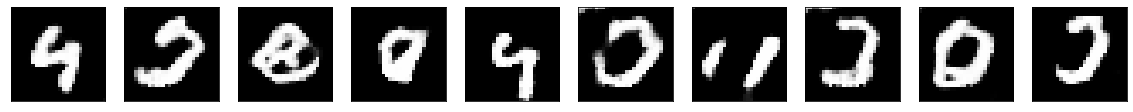

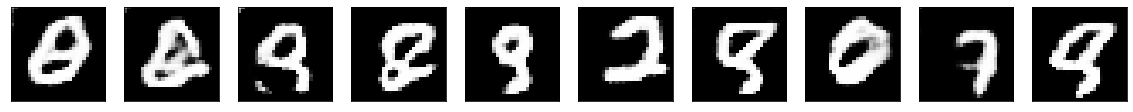

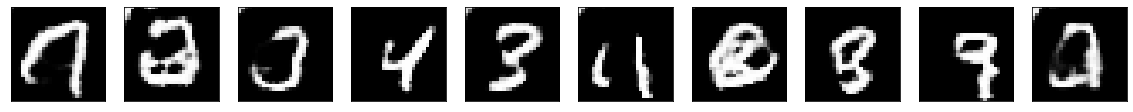

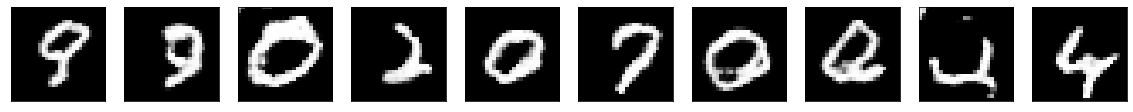

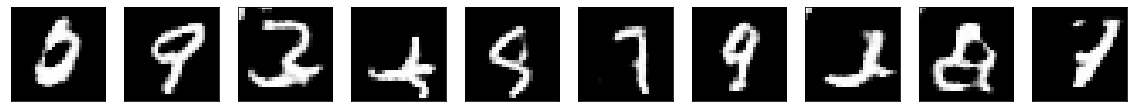

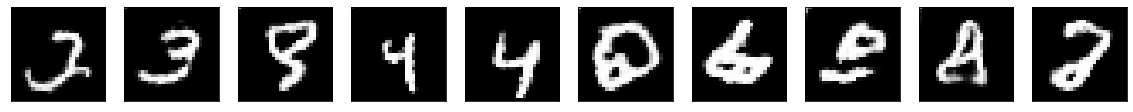

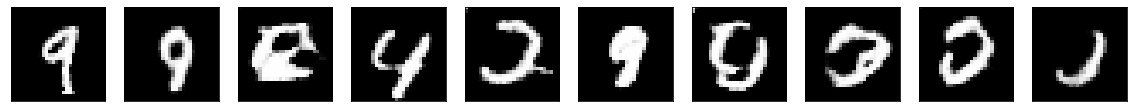

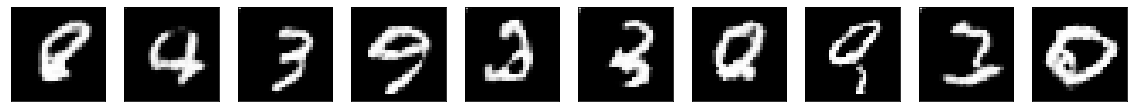

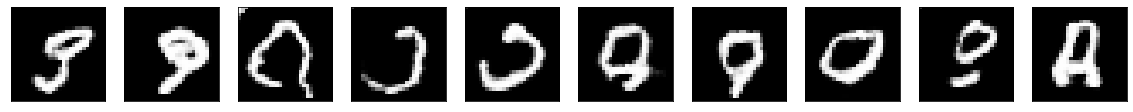

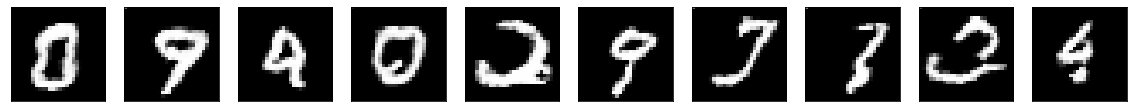

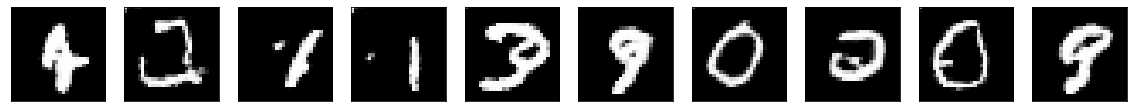

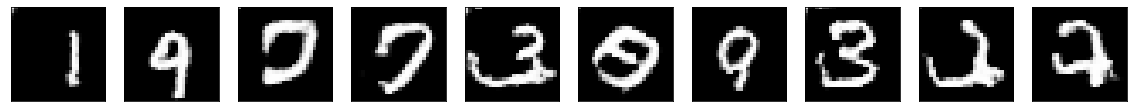

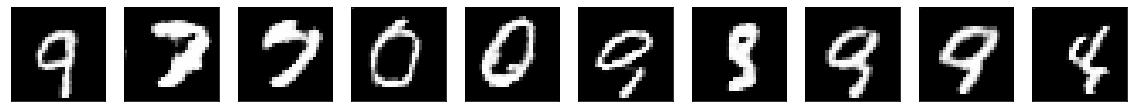

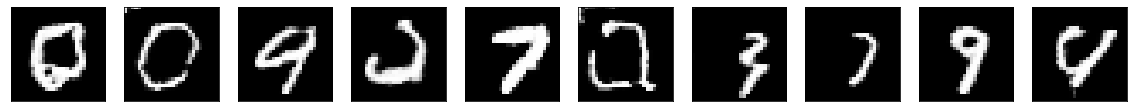

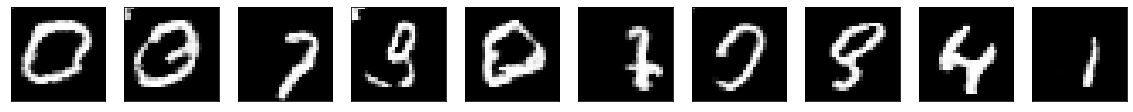

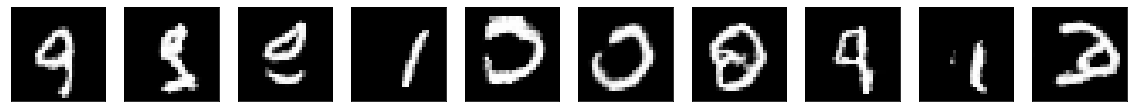

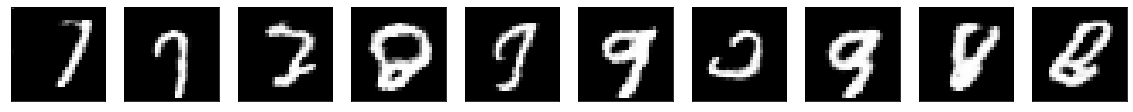

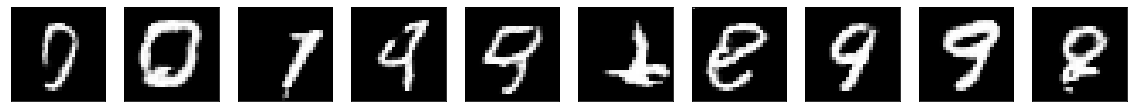

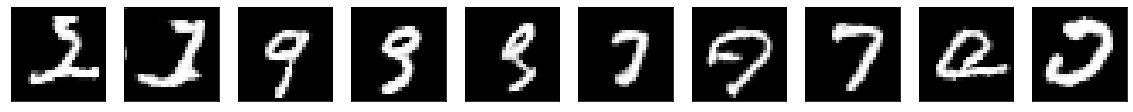

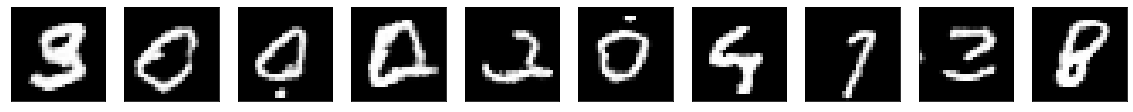

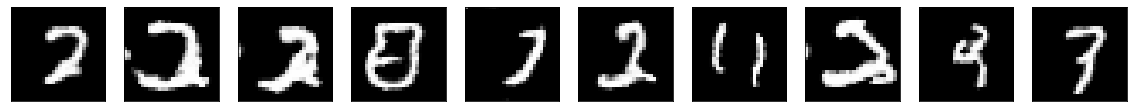

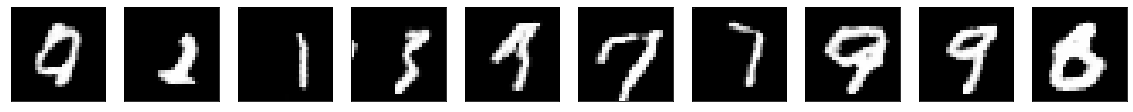

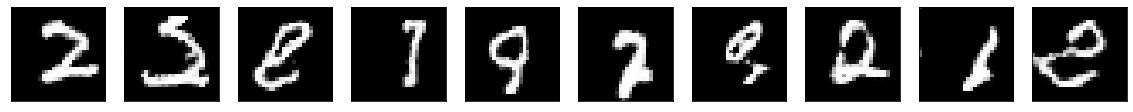

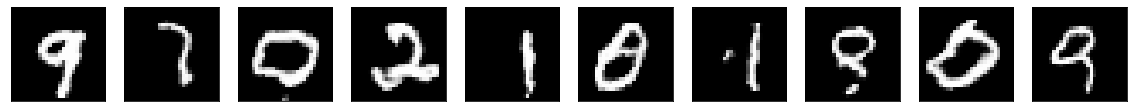

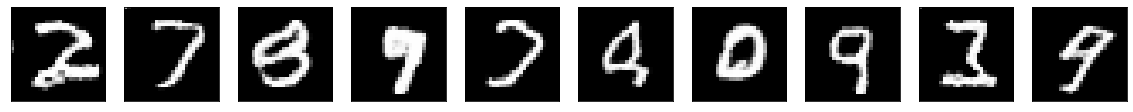

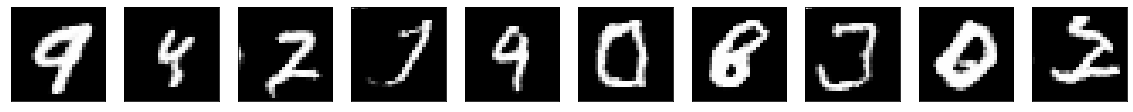

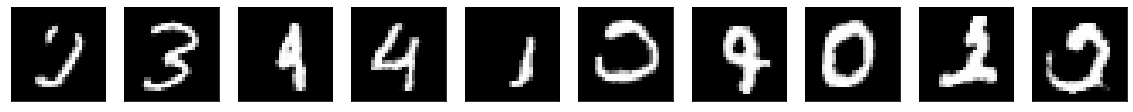

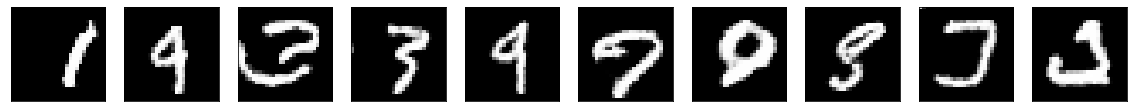

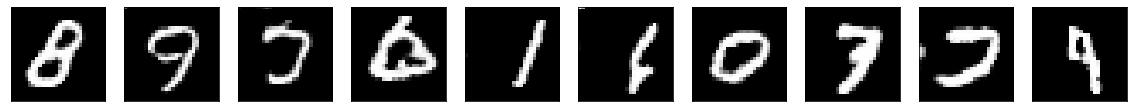

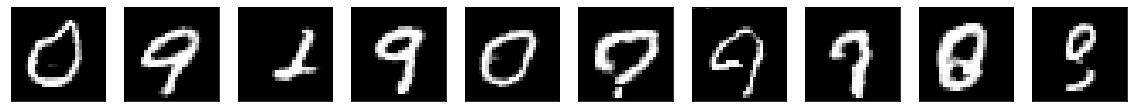

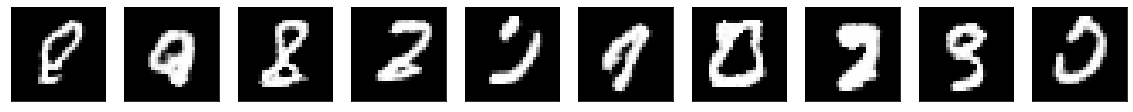

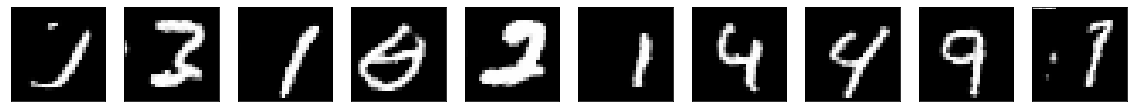

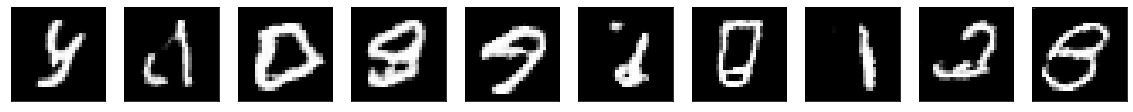

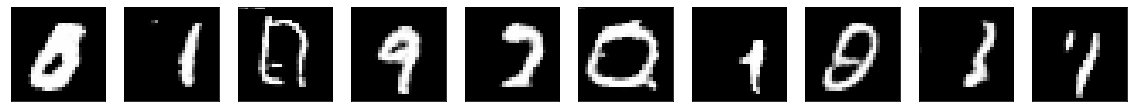

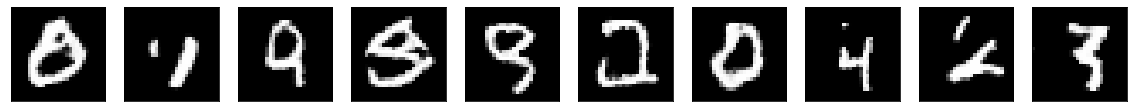

In [106]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=Adam(learning_rate=0.0003),
    g_optimizer=Adam(learning_rate=0.0003),
    loss_fn=BinaryCrossentropy(from_logits=True),
)

epochs = 50
num_img = 10
hist = gan.fit(
    dataset, 
    epochs=epochs,
    callbacks=[GANMonitor(num_img=num_img, latent_dim=latent_dim)]
)

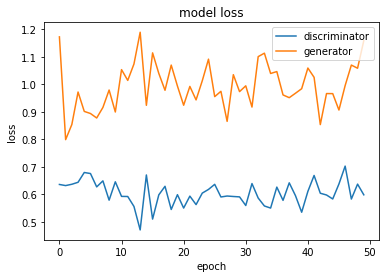

In [107]:
plt.plot(hist.history['d_loss'])
plt.plot(hist.history['g_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['discriminator', 'generator'], loc='upper right')
plt.show()